In [67]:
from torchvision.datasets import DatasetFolder
import torch
import numpy as np
from torch.utils.data import DataLoader, random_split

device = torch.device('cuda:0')
# load the stft dataset from folder

path = "spectrograms"

# loader function for .npy files
def npy_loader(path):
    x = np.load(path)
    x = np.expand_dims(x, axis=0)
    return torch.tensor(x, dtype=torch.float32)

dataset = DatasetFolder(root=path, loader=npy_loader, extensions=[".npy"])

train_ratio = 0.8
val_ratio = 0.2
dataset_size = len(dataset)
train_size = int(train_ratio * dataset_size)
val_size = dataset_size - train_size

# Split the dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    inputs, labels = zip(*batch)
    # inputs: list of tensors (1, freq, time)
    max_len = max(x.shape[-1] for x in inputs)
    padded = []
    for x in inputs:
        pad_len = max_len - x.shape[-1]
        if pad_len > 0:
            x = torch.nn.functional.pad(x, (0, pad_len))  # pad time dimension
        padded.append(x)
    return torch.stack(padded), torch.tensor(labels)
    
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,      
    num_workers=0,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,     
    num_workers=0,
    collate_fn=collate_fn
)
print("Finished loading the spectrograms")

Finished loading the spectrograms


In [82]:
print(len(train_loader))
print(len(val_loader))

187
47


In [129]:
import torch
import torch.nn as nn

class EmotionDetector(nn.Module):
    def __init__(self, layers, channels_in, channels_out, kernel_size, num_classes=6, n_fft=2048):
        super().__init__()

        self.convs = nn.ModuleList()

        self.layers = layers
        self.channels_out = channels_out
        self.channels_in = channels_in
        self.kernel_size = kernel_size
        self.channels_mult = channels_out

        for i in range(layers):
            self.convs.append(
                nn.Sequential(
                    nn.Conv2d(self.channels_in, self.channels_out, self.kernel_size, padding="same"),
                    nn.BatchNorm2d(self.channels_out),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(2),
                )
            )
            self.channels_in = self.channels_out
            self.channels_out = self.channels_mult * self.channels_in

        self.freq_pool = nn.AdaptiveAvgPool2d((None, 256))
        # self.lstm_input_size = 64 * 8
        # self.rnn = nn.GRU(self.lstm_input_size, 16, batch_first=True, bidirectional=True)
        # self.fc = nn.Linear(16*2, num_classes)
        self.fc1 = nn.Linear(262144, num_classes)

    def forward(self, x):
        batch_size = x.size(0)

        for conv in self.convs:
            x = conv(x)
        # x = self.freq_pool(x)
        x = self.freq_pool(x)

        x = x.flatten(start_dim=1)
        # x = x.permute(0, 3, 1, 2).contiguous().view(batch_size, x.size(3), -1)
        # x, _ = self.rnn(x)
        # x = x.mean(dim=1)
        x = self.fc1(x)
        return x

print("Memory-optimized model ready!")


Memory-optimized model ready!


Using device  cuda
lr: 0.01 hidden size: 64 in_channels: 1 out_channels: 2 kernel_size: 3 num epochs: 5


Epoch [1/5] Train Loss: 129.1019, Acc: 0.2777 Val Loss: 1.7549, Acc: 0.2599


Epoch [2/5] Train Loss: 2.0110, Acc: 0.1828 Val Loss: 1.7948, Acc: 0.1854


Epoch [3/5] Train Loss: 1.8170, Acc: 0.1823 Val Loss: 1.7933, Acc: 0.1659


Epoch [4/5] Train Loss: 1.8060, Acc: 0.1873 Val Loss: 1.7921, Acc: 0.1565


Epoch [5/5] Train Loss: 1.7716, Acc: 0.2118 Val Loss: 1.7826, Acc: 0.1887


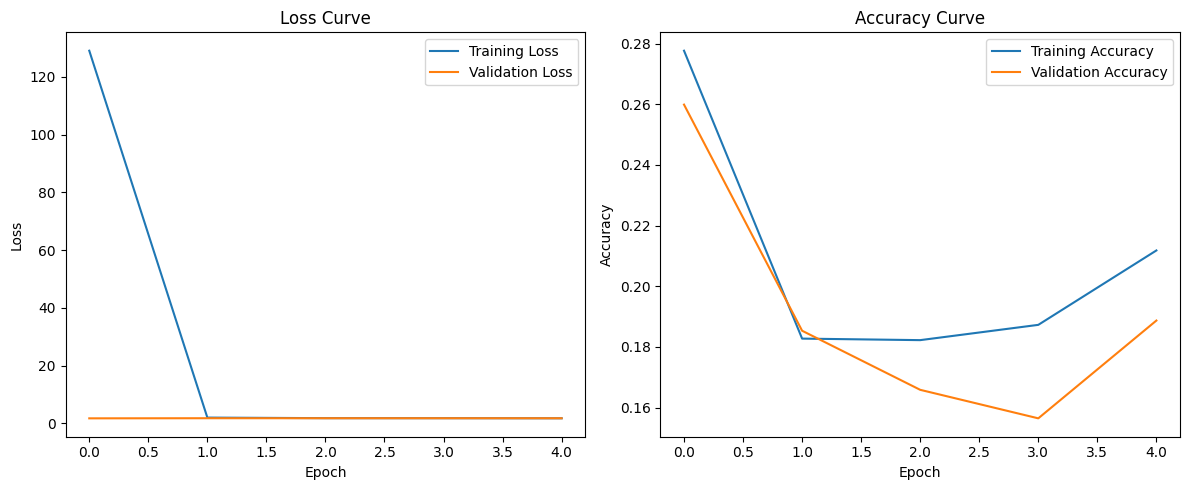

lr: 0.01 hidden size: 64 in_channels: 1 out_channels: 2 kernel_size: 5 num epochs: 5


Epoch [1/5] Train Loss: 81.6542, Acc: 0.2832 Val Loss: 1.7591, Acc: 0.3009


Epoch [2/5] Train Loss: 1.6245, Acc: 0.3378 Val Loss: 1.7318, Acc: 0.3707


KeyboardInterrupt: 

In [136]:
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import gc


def train_model(model, train_loader, val_loader, num_epochs, lr, device='cuda'):
    """
    Train a CNN+LSTM model for emotion recognition with progress bars.

    Args:
        model: PyTorch nn.Module
        train_loader: DataLoader for training set
        val_loader: DataLoader for validation set
        num_epochs: number of epochs
        lr: learning rate
        device: 'cuda' or 'cpu'
    """

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Training loop with tqdm
        train_loader_iter = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Train]", leave=False)
        for inputs, labels in train_loader_iter:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            train_loader_iter.set_postfix({'loss': running_loss / total, 'acc': correct / total})

        epoch_loss = running_loss / total
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)

        # Validation loop with tqdm
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        val_loader_iter = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Val]", leave=False)
        with torch.no_grad():
            for val_inputs, val_labels in val_loader_iter:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

                val_outputs = model(val_inputs)
                v_loss = criterion(val_outputs, val_labels)

                val_loss += v_loss.item() * val_inputs.size(0)
                _, val_pred = val_outputs.max(1)
                val_correct += (val_pred == val_labels).sum().item()
                val_total += val_labels.size(0)

                val_loader_iter.set_postfix({'val_loss': val_loss / val_total, 'val_acc': val_correct / val_total})

        val_loss /= val_total
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Epoch [{epoch + 1}/{num_epochs}] "
              f"Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f} "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    # Plot loss and accuracy curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return model


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device ", device)

param_grid = {
    'lr': [1e-2, 1e-3, 1e-4],
    'hidden_size': [64, 128, 256],
    'num_layers': [2, 3, 4],
    'in_channels': [1],
    'out_channels': [2],
    'kernel_size': [3, 5],
    'num_epochs': [5]
}

for lr in param_grid['lr']:
    for hidden_layer_size in param_grid['hidden_size']:
        for num_conv_layers in param_grid['num_layers']:
            for in_channels in param_grid['in_channels']:
                for out_channels in param_grid['out_channels']:
                    for kernel_size in param_grid['kernel_size']:
                        for num_epochs in param_grid['num_epochs']:
                            print(f"lr: {lr} hidden size: {hidden_layer_size} in_channels: {in_channels}"
                                  f" out_channels: {out_channels} kernel_size: {kernel_size} num epochs: {num_epochs}")
                            m = EmotionDetector(num_conv_layers, in_channels, out_channels, kernel_size).to(device)
                            train_model(m, train_loader, val_loader, num_epochs, lr, device=device)
                            torch.cuda.empty_cache()
                            gc.collect()
                            del m 


In [131]:
import torch
torch.cuda.empty_cache()
import gc
gc.collect()
del m 

In [56]:
load = iter(train_loader)
feature, label = next(load)
print(feature.shape)

torch.Size([32, 1, 1025, 310])


In [75]:
c = 0
l = []
for name, param in m.named_parameters():
    c+=param.numel()
    l.append(param.numel())
l.sort()
print(l[len(l)//2])
print(l)
print(c)

18
[2, 4, 6, 8, 18, 72, 288, 1572864]
1573262


In [81]:
for name, param in m.named_parameters():
    print()
    print(name)
    print(param.flatten().cpu().median())
    print(param.flatten().cpu().std())


conv1.0.weight
tensor(0.0592, grad_fn=<MedianBackward0>)
tensor(0.1483, grad_fn=<StdBackward0>)

conv1.0.bias
tensor(-0.3799, grad_fn=<MedianBackward0>)
tensor(0.2572, grad_fn=<StdBackward0>)

conv2.0.weight
tensor(-0.0322, grad_fn=<MedianBackward0>)
tensor(0.1392, grad_fn=<StdBackward0>)

conv2.0.bias
tensor(-0.1715, grad_fn=<MedianBackward0>)
tensor(0.1821, grad_fn=<StdBackward0>)

conv3.0.weight
tensor(-0.0349, grad_fn=<MedianBackward0>)
tensor(0.1090, grad_fn=<StdBackward0>)

conv3.0.bias
tensor(-0.0573, grad_fn=<MedianBackward0>)
tensor(0.0832, grad_fn=<StdBackward0>)

fc1.weight
tensor(-8.1746e-05, grad_fn=<MedianBackward0>)
tensor(0.0212, grad_fn=<StdBackward0>)

fc1.bias
tensor(-0.0040, grad_fn=<MedianBackward0>)
tensor(0.0328, grad_fn=<StdBackward0>)
